In [13]:
import random
import torch
from tqdm import tqdm


class DynamicNet(torch.nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(DynamicNet, self).__init__()
    self.fc1 = torch.nn.Linear(input_size, hidden_size)
    self.activ1 = torch.nn.ReLU()
    self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
    self.activ2 = torch.nn.ReLU()
    self.fc3 = torch.nn.Linear(hidden_size, output_size)

  def forward(self, x):
    x = self.fc1(x)
    x = self.activ1(x)
    x = self.fc2(x)
    x = self.activ2(x)
    x = self.fc3(x)
    return x


# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 100, 4, 20, 1

# Create random Tensors to hold inputs and outputs
x = torch.rand(N, D_in)*2 - 1
y = torch.rand(N, D_out)*2 - 1

# Construct our model by instantiating the class defined above
model = DynamicNet(D_in, H, D_out)
model.train()
# Construct our loss function and an Optimizer. Training this strange model with
# vanilla stochastic gradient descent is tough, so we use momentum
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
for t in range(50000):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    if t % 1000 == 99:
        print(t, loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

99 28.78569221496582
1099 12.916375160217285
2099 4.167008876800537
3099 1.3895654678344727
4099 0.435881108045578
5099 0.2109106183052063
6099 0.11253813654184341
7099 0.06334838271141052
8099 0.035869210958480835
9099 0.020667608827352524
10099 0.011898571625351906
11099 0.00690759951248765
12099 0.0041022347286343575
13099 0.0024592254776507616
14099 0.0014823294477537274
15099 0.0008906321018002927
16099 0.0005338480696082115
17099 0.00032084499252960086
18099 0.00019133079331368208
19099 0.00011423599062254652
20099 6.835364183643833e-05
21099 4.0606049878988415e-05
22099 2.4192628188757226e-05
23099 1.4446301975112874e-05
24099 8.477663868688978e-06
25099 5.048070761404233e-06
26099 3.001139020852861e-06
27099 1.7674078662821557e-06
28099 1.0442764732943033e-06
29099 6.215636858541984e-07
30099 3.7959972587486845e-07
31099 2.3200445298243721e-07
32099 1.4903210399097588e-07
33099 1.0181212672932816e-07
34099 7.425991555010114e-08
35099 5.657076940224215e-08
36099 4.44588579284754

In [14]:
model.eval()
x_test = torch.randn(100, 4)
y_test = model(x_test)
print(list([1 if i > 0 else 0 for i in y_test.squeeze()]))

[1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0]


In [15]:
import numpy as np
size = 5000
samples = []
key_size = 32
tail = key_size % 3
frequency = []
k = 101
for i in range(k):
  frequency.append(0)
etalonFreq = 1 / k
etalonNum = size / k
for i in range(size):
  samples.append(0)
  x_test = torch.randn(100, 4)
  y_test = list([i.item() for i in model(x_test).squeeze()])
  y_test = list([(int)(i * 10000000) % 10  for i in y_test if (int)(i * 10000000) % 10 < 8])
# print(y_test, len(y_test))
  for j in range(0, key_size//3):
    samples[i] = (samples[i] << 3) | y_test[j]
  samples[i] = (samples[i] << tail) | (y_test[key_size] & (2**tail - 1))
  samples[i] = samples[i] / (2**key_size)
  frequency[(int)(samples[i] // etalonFreq)] += 1;
  # print(samples[i], (int)(samples[i] // etalonFreq))


In [16]:


hi = 0
for i in range(k):
  hi += (frequency[i] - etalonNum)**2;
hi *= 1 / etalonNum;
print(hi)

79.89599999999999


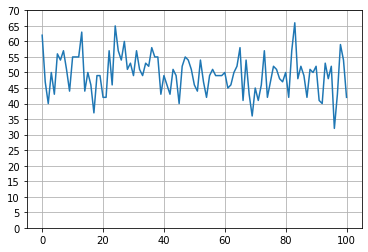

In [17]:
import matplotlib.pyplot as plt
plt.plot(frequency)
plt.yticks(np.arange(0,75,5))
plt.grid()
plt.show()

In [18]:
print(np.mean(frequency))

49.504950495049506


In [19]:
print(np.mean(samples))

0.4929196330538485


In [20]:
print(np.std(samples)**2)

0.08326980499512915


In [82]:
with open('generated_samples_3.bin', 'wb') as fout:
    size = 10000000
    sample = 0
    key_size = 32
    tail = key_size % 3
    for i in tqdm(range(size)):
        sample = 0
        x_test = torch.randn(30, 4)
        y_test = list([i.item() for i in model(x_test).squeeze()])
        y_test = list([(int)(i * 10000000) % 10  for i in y_test if (int)(i * 10000000) % 10 < 8])
        for j in range(0, key_size//3):
            sample = (sample << 3) | y_test[j]
        sample = (sample << tail) | (y_test[len(y_test) - 1] & (2**tail - 1))
        fout.write(sample.to_bytes(4, byteorder='big', signed=False))

100%|██████████| 10000000/10000000 [1:23:02<00:00, 2007.08it/s]


In [58]:
from tqdm import tqdm
for i in tqdm(range(10000)):
        x_test = torch.randn(1, 4)
        y_test = model(x_test).item()
        #fout.write(str(0) if y_test < 0 else str(1))


100%|██████████| 10000/10000 [00:01<00:00, 5439.38it/s]


In [48]:
bin(0)


'0b0'